# ECE 450 - Exam #3

## Package Imports


In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal as sig
from control import margin, tf


## Generic function to convolve any number of equations


In [2]:
def convolve_all(values):
    temp_conv = values[0]
    if len(values) > 1:
        for next_val in values[1:]:
            temp_conv = np.convolve(temp_conv, next_val)
    
    return temp_conv


## Generic function to plot the responses of a system


In [3]:
# Color list for multiple lines on each subplot
colors = ["red", "blue", "green", "gray", "purple", "orange"]
step_size = 0.005

# Generic Function to create a plot
def create_plot(x, y, xLabel=["X-Values"], yLabel=["Y-Values"],
                title=[("Plot", )], num_rows=1, size=(18, 14), logx=False):
    plt.figure(figsize=size, dpi=300)
    for c, (x_vals, y_vals, x_labels, y_labels, titles) in enumerate(zip(x, y, xLabel, yLabel, title)):
        for c2, (y_v, t) in enumerate(zip(y_vals, titles)):
            plt.subplot(num_rows, 1, c + 1)
            # Add a plot to the subplot, use transparency so they can both be seen
            plt.plot(x_vals, y_v, label=t, color=colors[c2], alpha=0.70)
            plt.ylabel(y_labels)
            plt.xlabel(x_labels)
            plt.grid(True)
            plt.legend(loc='lower right')
            if logx:
                plt.xscale("log")
    
    plt.show()


## Generic function shift a given filter to a new center frequency


In [4]:
def shift_filter(num, den, new_center):
    new_num = np.pad(num, (len(den) - len(num), 0), 'constant')
    new_den = den

    for i in range(len(new_den)):
        new_num[i] *= (new_center ** i)
        new_den[i] *= (new_center ** i)
        
    return new_num, new_den


## Generic function to convert a low-pass filter to a high-pass filter


In [5]:
def low_to_high(num, den):
    return np.flip(np.pad(num, (len(den)-len(num), 0), 'constant')), np.flip(den)

Let's start with a simple Butterworth Filter design that meets these criteria:

$$\omega _p \geq 400, |H_p|\geq 0.9$$

$$\omega _s \leq 200, |H_s|\leq 0.1$$

In order to implement the Butterworth design procedure, the filter must be a low-pass with a cutoff frequency of $\omega _c = 1$. I will start by selecting a center frequency of 300. 

Thus, the pass and stopband frequencies need to be moved as follows:

$$\omega _p = \frac{1}{\frac{400}{300}}=0.75, \omega _s =\frac{1}{\frac{200}{300}}=1.5$$

Now, let's look at the order requirements for each of these two criteria:

$$n_p=\frac{log_{10}(\frac{1}{H_p^2}-1)}{2log_{10}(\omega _p)}=\frac{log_{10}(\frac{1}{0.9^2}-1)}{2log_{10}(0.75)}=2.75$$

$$n_s=\frac{log_{10}(\frac{1}{H_s^2}-1)}{2log_{10}(\omega _p)}=\frac{log_{10}(\frac{1}{0.1^2}-1)}{2log_{10}(1.5)}=5.67$$

Clearly, I'd need a sixth order filter in order to meet these requirements.

Num:  [1] 
Den:  [1.         3.86370331 7.46410162 9.14162017 7.46410162 3.86370331
 1.        ]


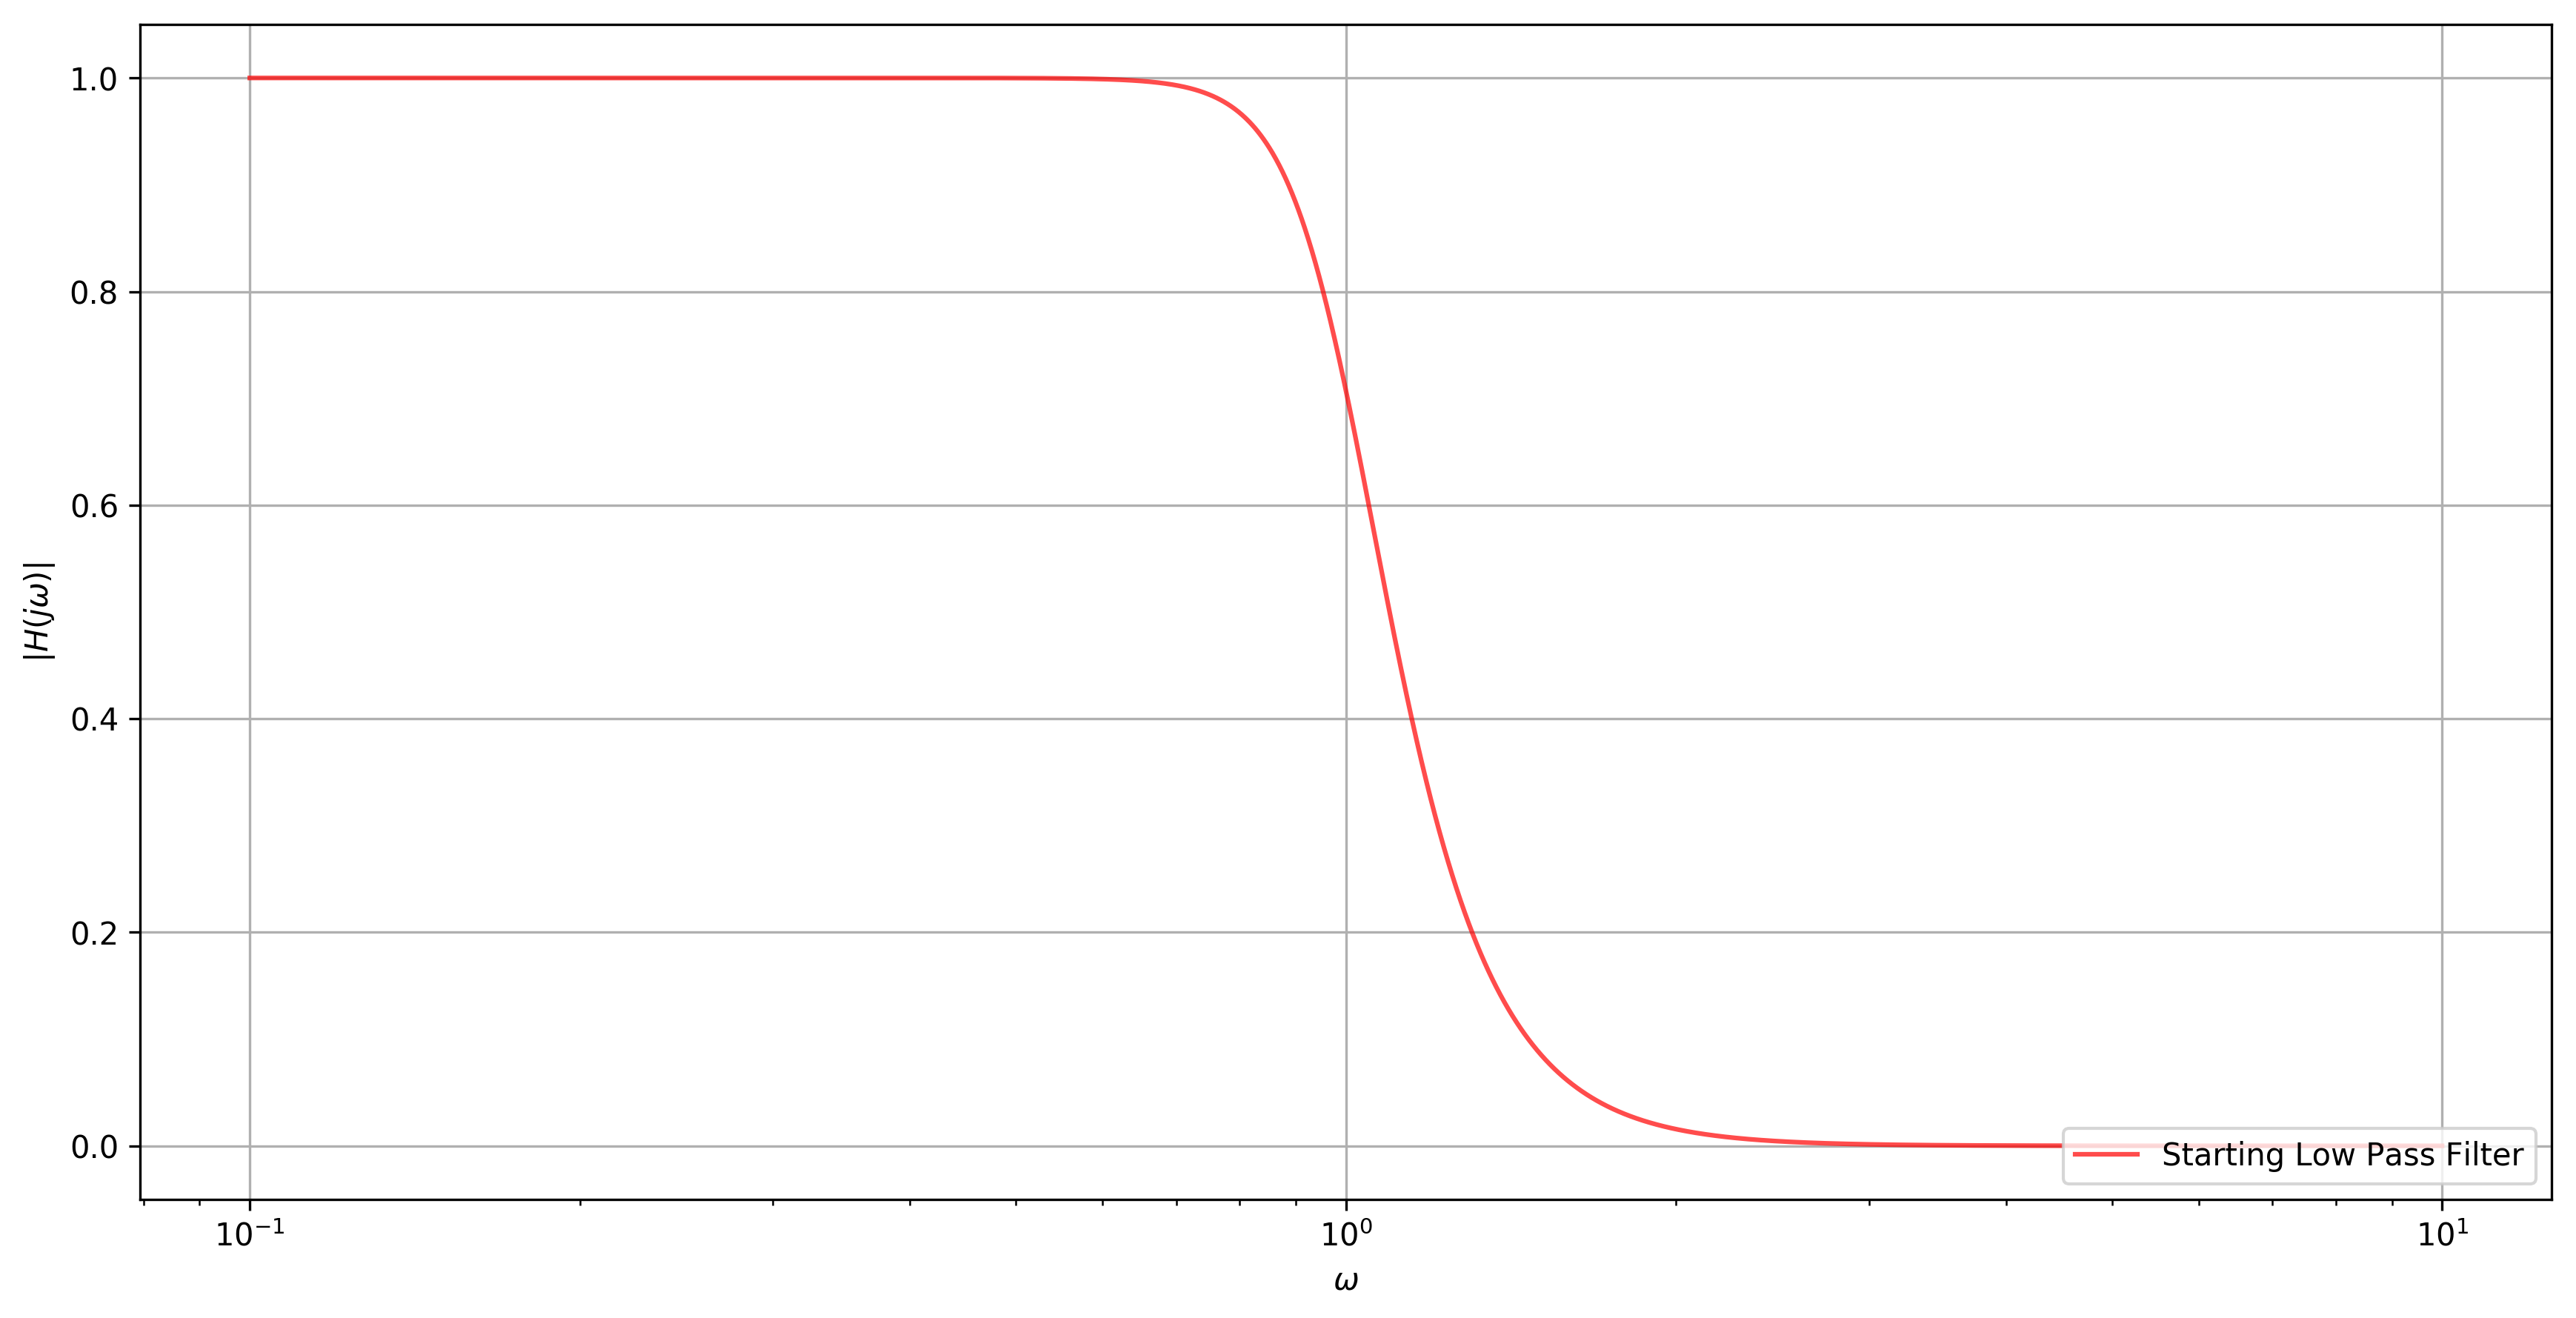

In [15]:
n = 6

pole_list = []
for m in range(1, n + 1):
    phi = np.pi / 2 + np.pi / 2 * (2 * m - 1) / n
    pole_list.append(complex(np.cos(phi), np.sin(phi)))
    
num = [1]
den = convolve_all([[1, -pole] for pole in pole_list])
print ("Num: ", num, "\nDen: ", np.real(den))

system = sig.lti(num, den)
w, h_mag, h_phase = sig.bode(system, np.arange(0.1, 10, 0.001))
create_plot([w], [(10 ** (0.05 * h_mag), )], ["$\omega$"], ["$|H(j\omega)|$"],
            [("Starting Low Pass Filter", )], size=(14, 7), logx=True)

Let's change this to a Chebychev II filter.

Epsilon: 0.101
n: 5.000
Alpha: 19.950
a: 0.635
b: 1.185

Num:  [ 5.02518908e-01 -1.27111376e-31  2.01007563e+00 -1.69481835e-31
  1.60806050e+00] 
Den:  [1.         3.24707087 5.14547198 5.40570185 3.30465502 1.6080605 ]


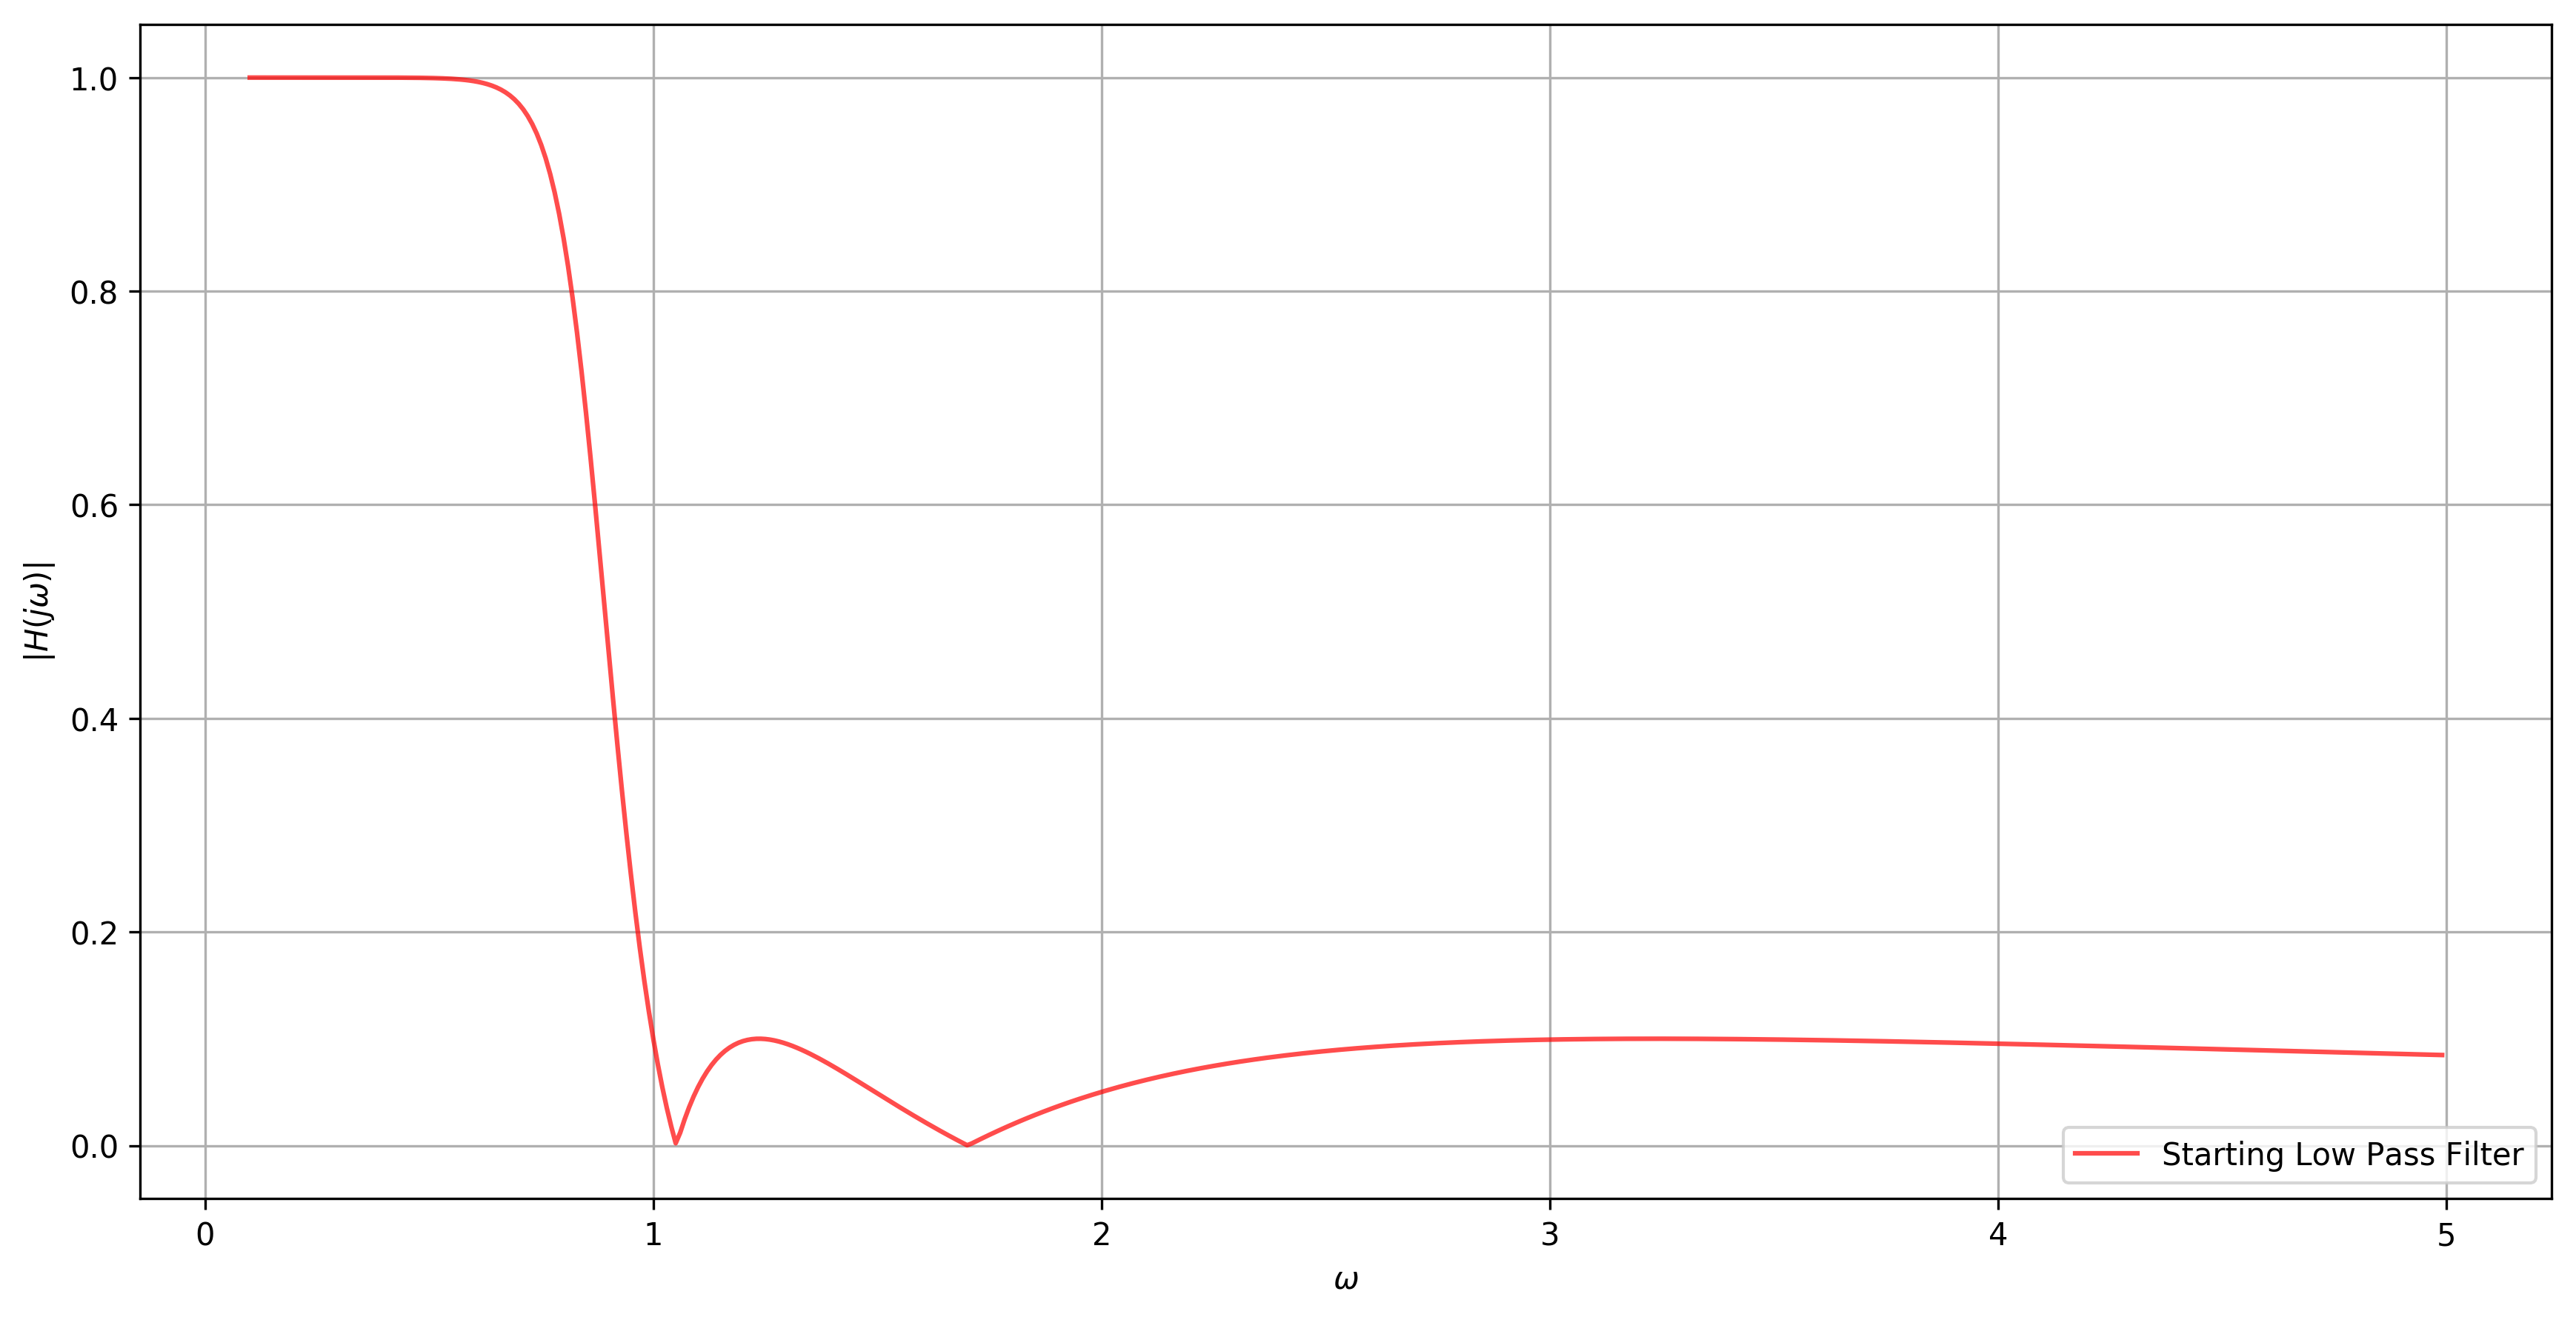

In [7]:
h_s = 0.1
h_p = 0.9
w_s = 1.5
w_p = 0.75

epsilon = np.sqrt(h_s ** 2 / (1 - h_s ** 2))
n = int(np.ceil(np.arccosh(np.sqrt(1 / (epsilon ** 2 * (1 - h_p ** 2)))) / np.arccosh(1 / w_p)))
alpha = 1 / epsilon + np.sqrt(1 + 1 / (epsilon ** 2))
a = 0.5 * (alpha ** (1 / n) - alpha ** (-1 / n))
b = 0.5 * (alpha ** (1 / n) + alpha ** (-1 / n))
print ("Epsilon: {:.3f}\nn: {:.3f}\nAlpha: {:.3f}\na: {:.3f}\nb: {:.3f}\n".format(epsilon, n, alpha, a, b))

# Develop the poles (denomenator) for the ChevyChase Type II
pole_list = []
for m in range(1, n + 1):
    phi = np.pi / 2 + np.pi / 2 * (2 * m - 1) / n
    pole_list.append(1 / complex(a * np.cos(phi), b * np.sin(phi)))
den_chev2 = convolve_all([[1, -pole] for pole in pole_list])

# Develop the zeros (numerator) for the Chevy-chase Type II
zero_list = [1 / np.cos(k * np.pi / (2 * n)) for k in range(1, 2 * n, 2)]
zero_list = [zero for zero in zero_list if zero < 10 ** 10]
num_chev2 = convolve_all([[1, complex(0, -zero)] for zero in zero_list])
K = den_chev2[-1] / num_chev2[-1]
num_chev2 = np.multiply(K, num_chev2)

print ("Num: ", np.real(num_chev2), "\nDen: ", np.real(den_chev2))

system = sig.lti(num_chev2, den_chev2)
w, h_mag, h_phase = sig.bode(system, np.arange(0.1, 5, 0.01))
create_plot([w], [(10 ** (0.05 * h_mag), )], ["$\omega$"], ["$|H(j\omega)|$"],
            [("Starting Low Pass Filter", )], size=(14, 7))

Num:  [ 1.60806050e+00 -1.69481835e-31  2.01007563e+00 -1.27111376e-31
  5.02518908e-01  0.00000000e+00] 
Den:  [1.6080605  3.30465502 5.40570185 5.14547198 3.24707087 1.        ]


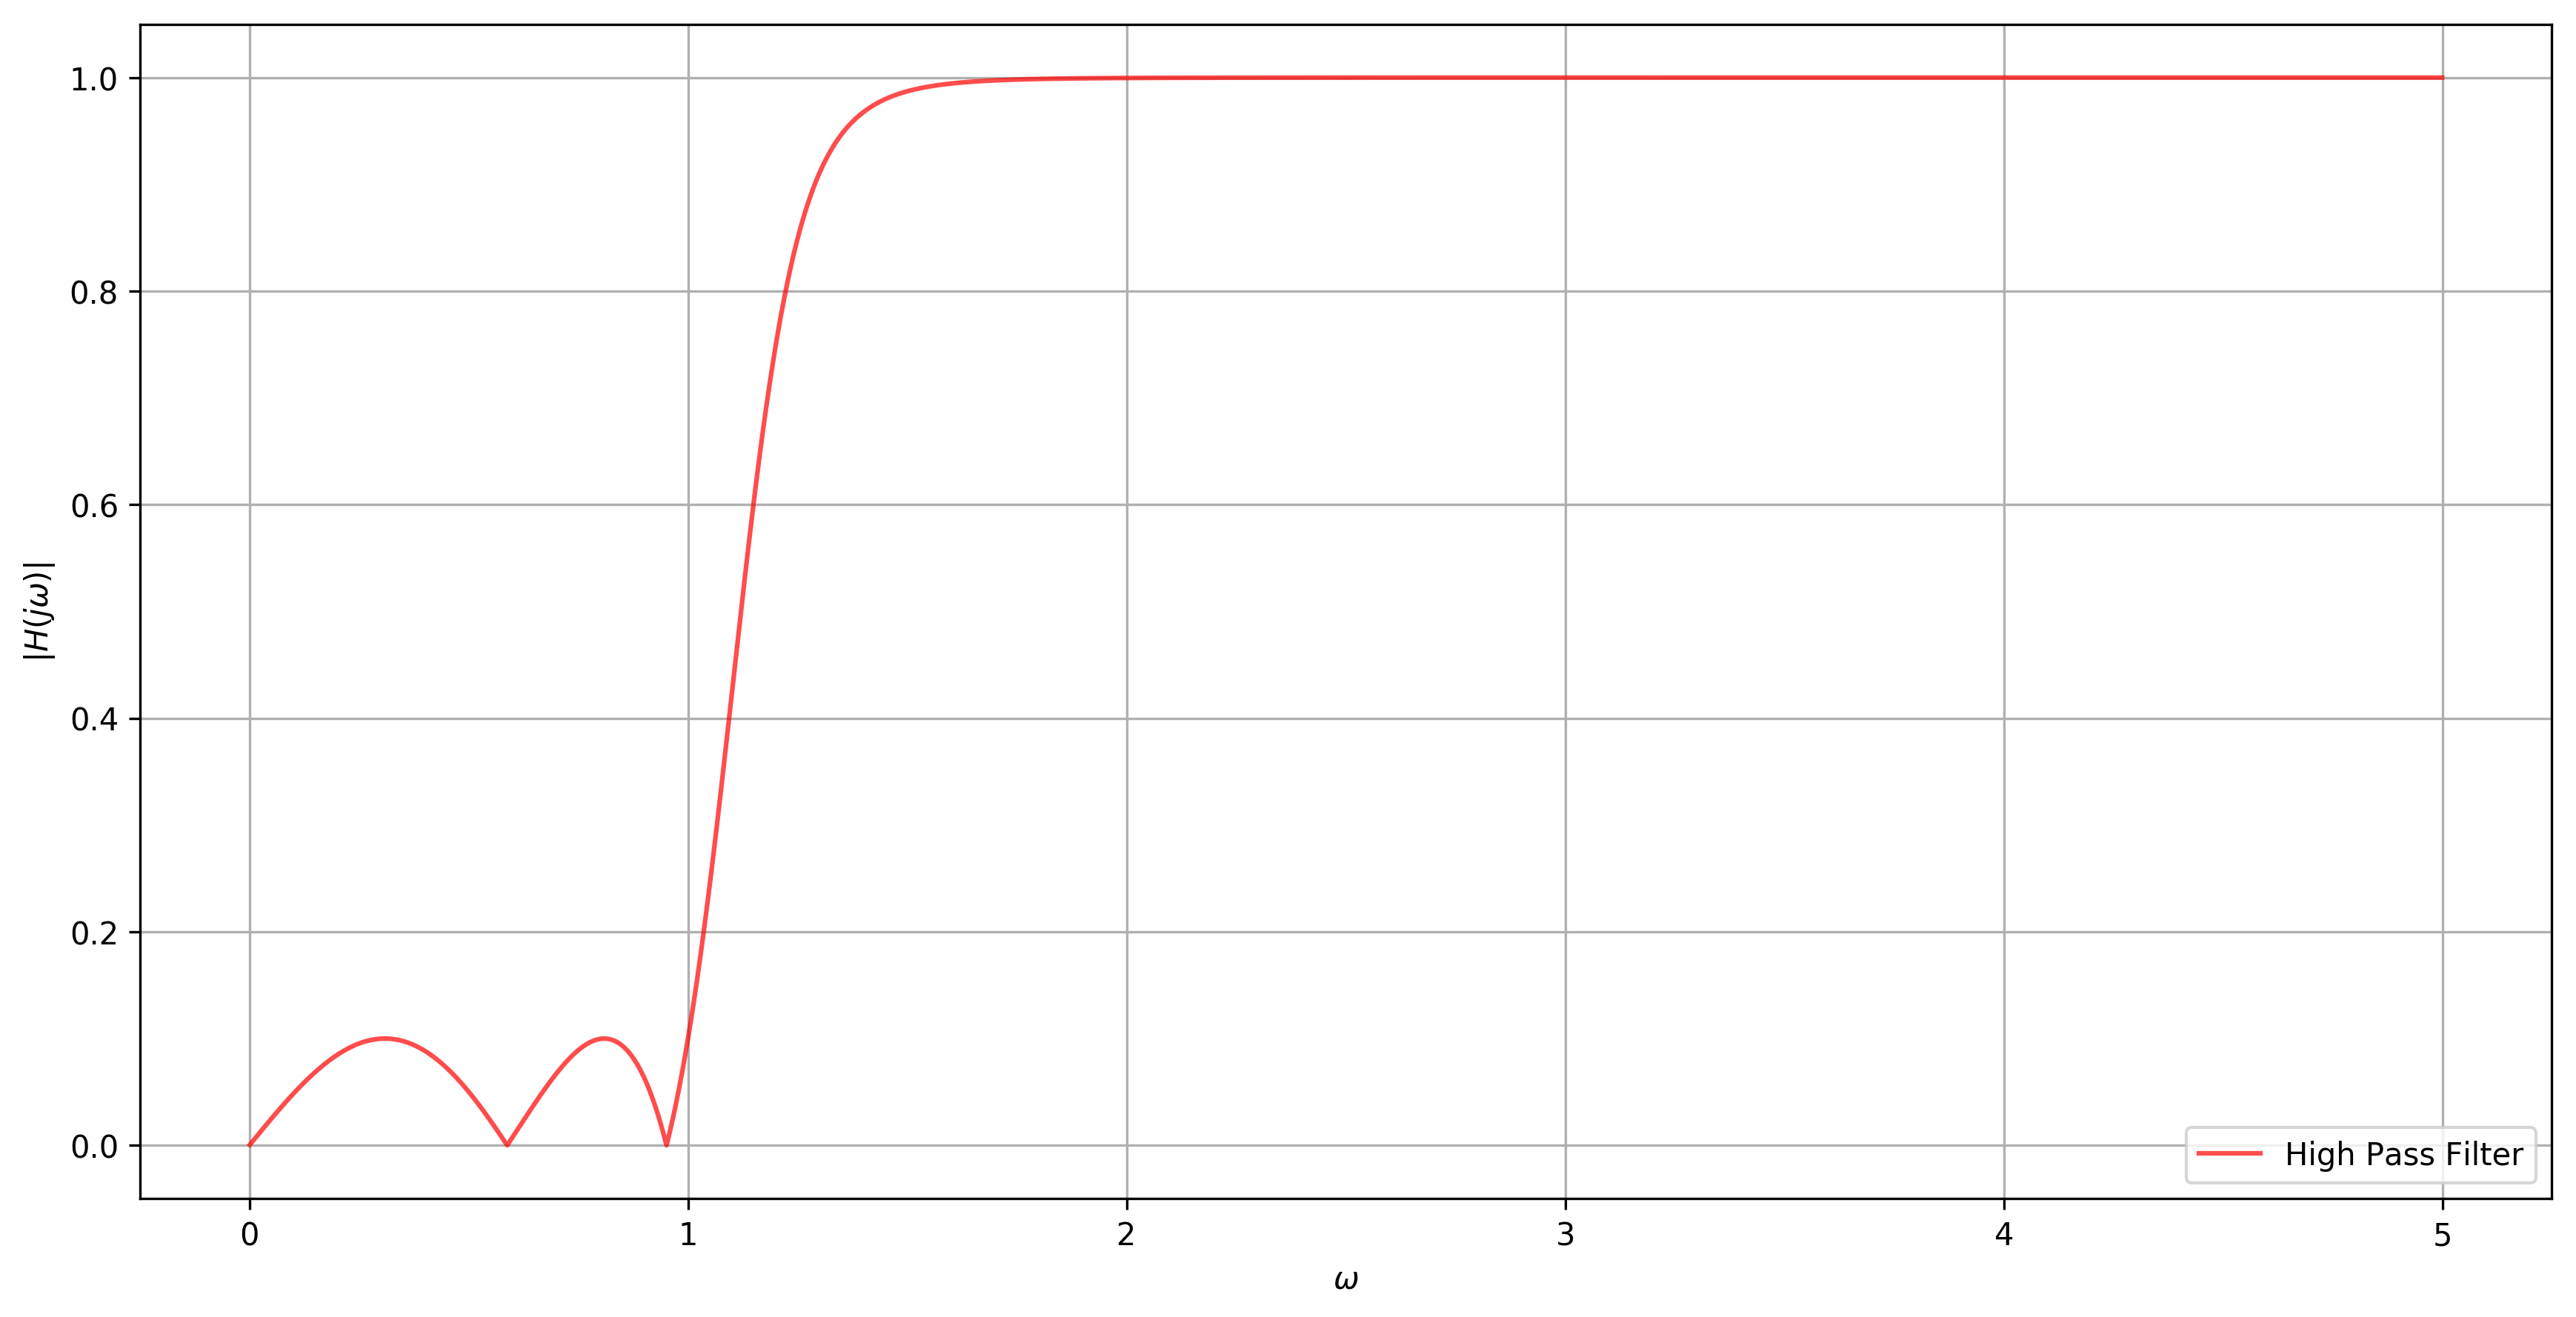

In [8]:
num_chev2, den_chev2 = low_to_high(num_chev2, den_chev2)
print ("Num: ", np.real(num_chev2), "\nDen: ", np.real(den_chev2))

system = sig.lti(num_chev2, den_chev2)
w, h_mag, h_phase = sig.bode(system, np.arange(0.001, 5, 0.001))
create_plot([w], [(10 ** (0.05 * h_mag), )], ["$\omega$"], ["$|H(j\omega)|$"],
            [("High Pass Filter", )], size=(14, 7))

Num:  [ 1.60806050e+00 -5.08445505e-29  1.80906807e+05 -3.43200716e-24
  4.07040315e+09  0.00000000e+00] 
Den:  [1.60806050e+00 9.91396507e+02 4.86513166e+05 1.38927744e+08
 2.63012740e+10 2.43000000e+12]


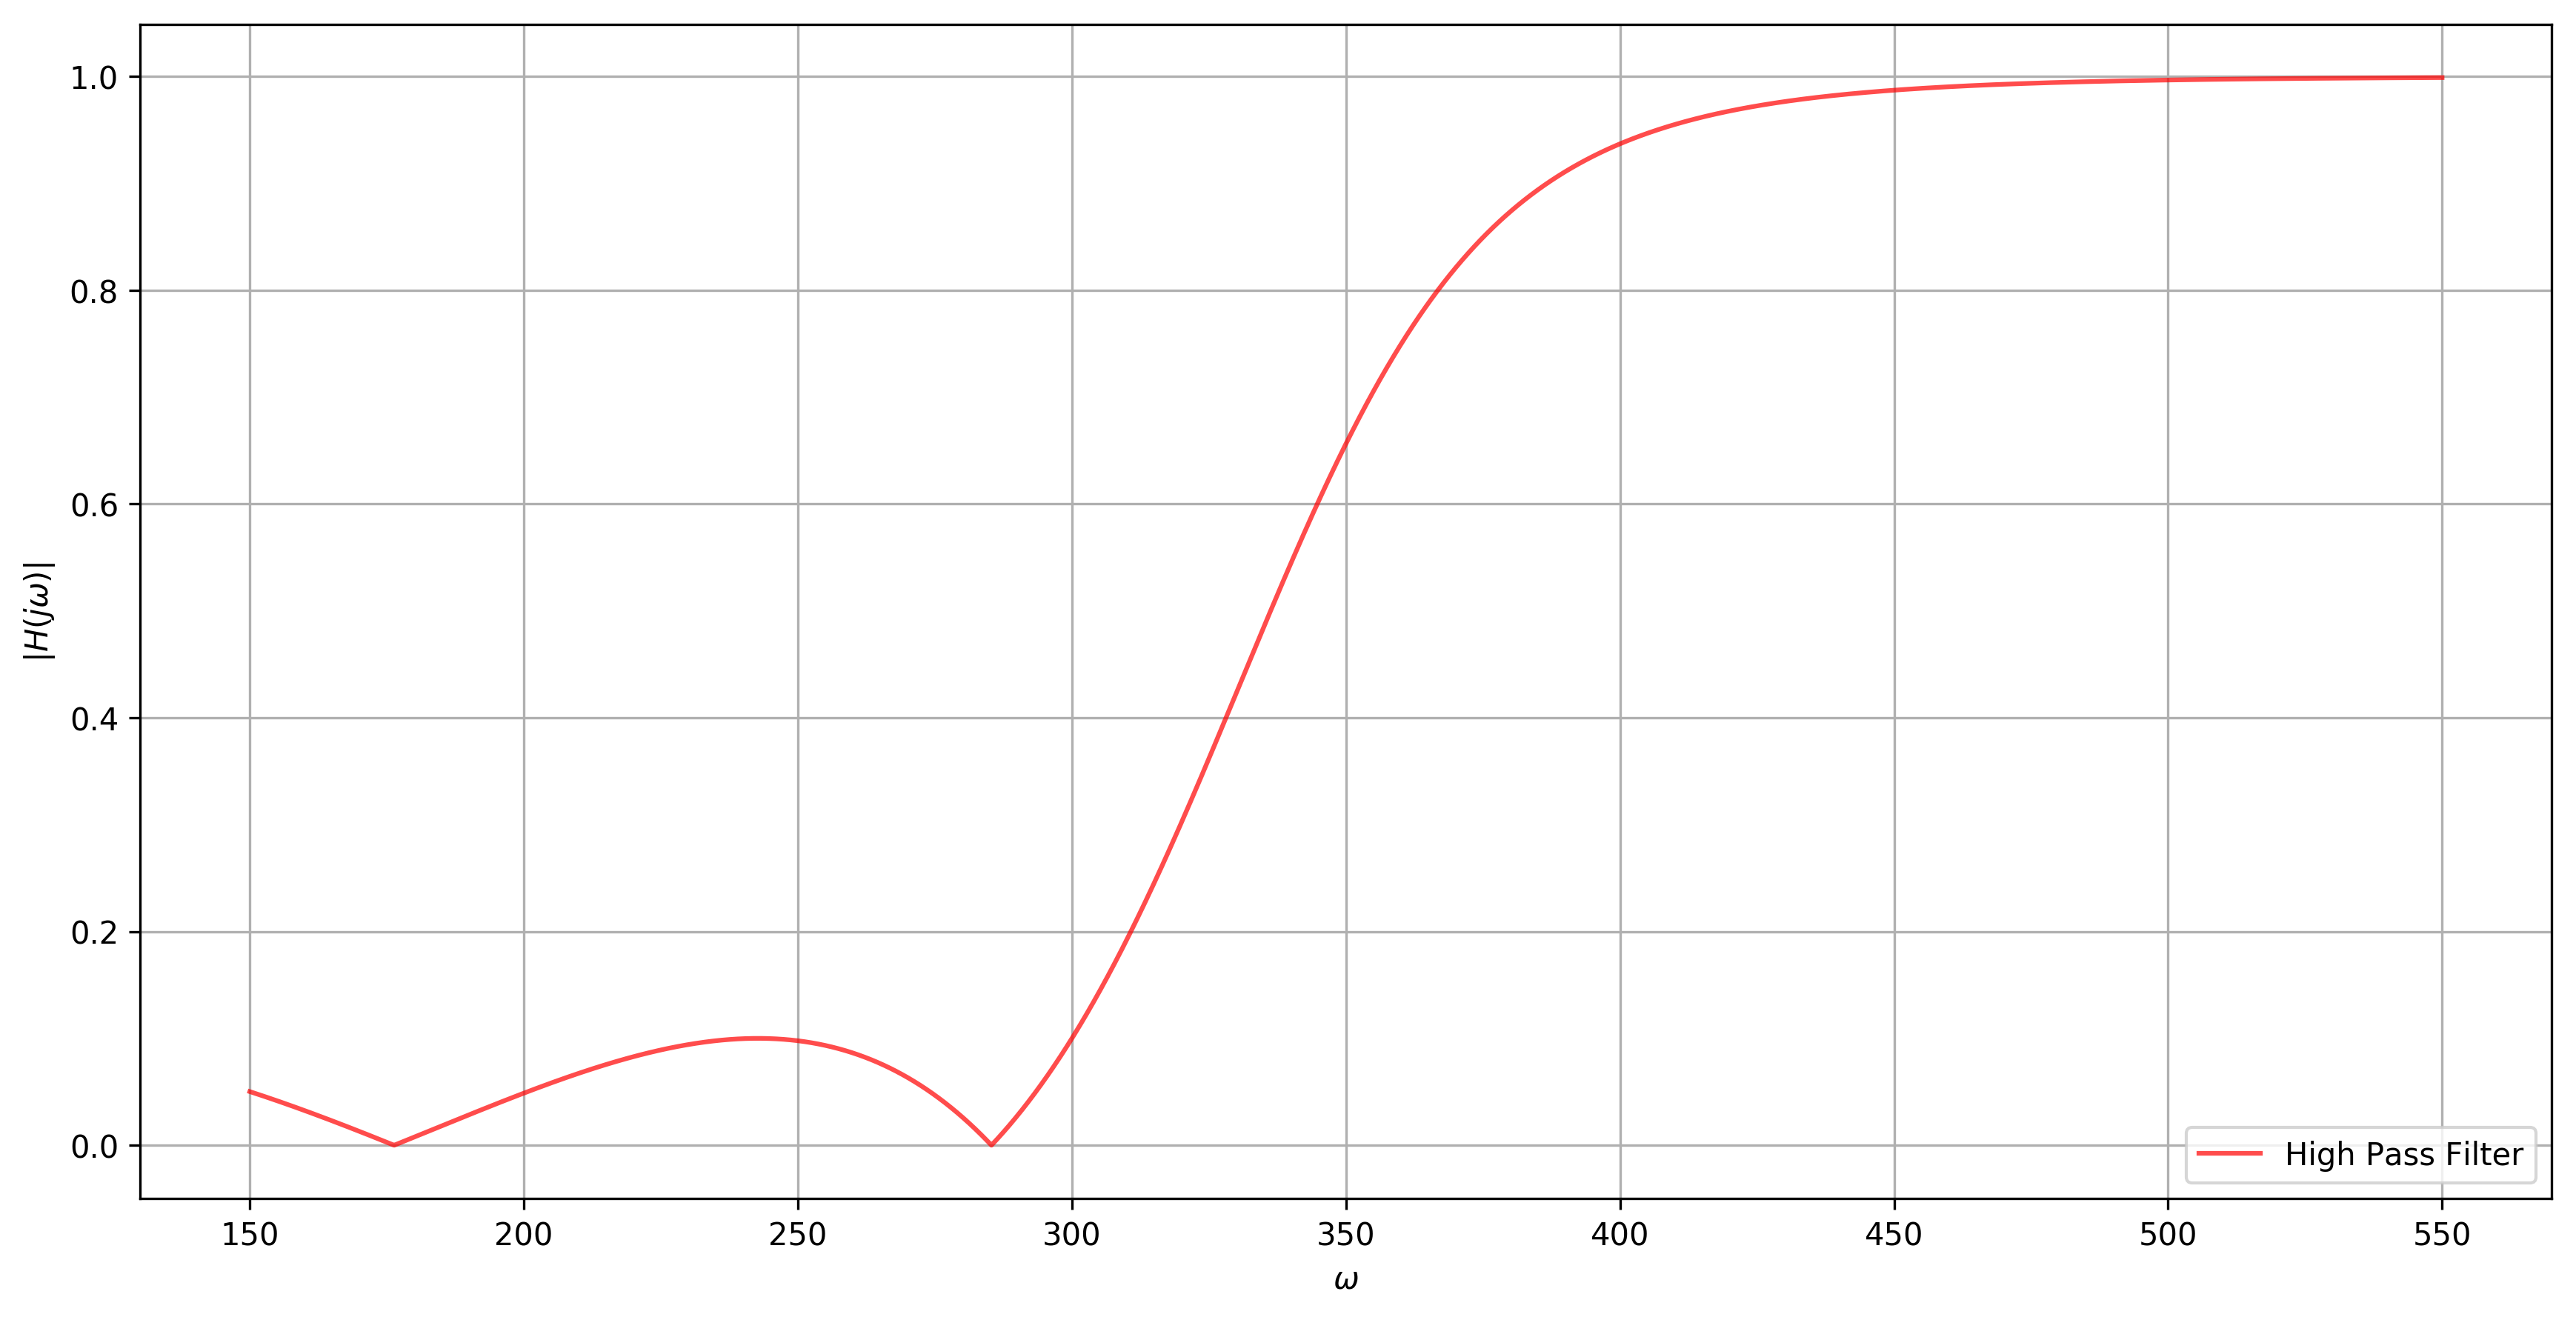

In [9]:
final_num, final_den = shift_filter(num_chev2, den_chev2, 300)
print ("Num: ", np.real(final_num), "\nDen: ", np.real(final_den))
      
system = sig.lti(final_num, final_den)
w, h_mag, h_phase = sig.bode(system, np.arange(150, 550, 0.01))
create_plot([w], [(10 ** (0.05 * h_mag), )], ["$\omega$"], ["$|H(j\omega)|$"],
            [("High Pass Filter", )], size=(14, 7))

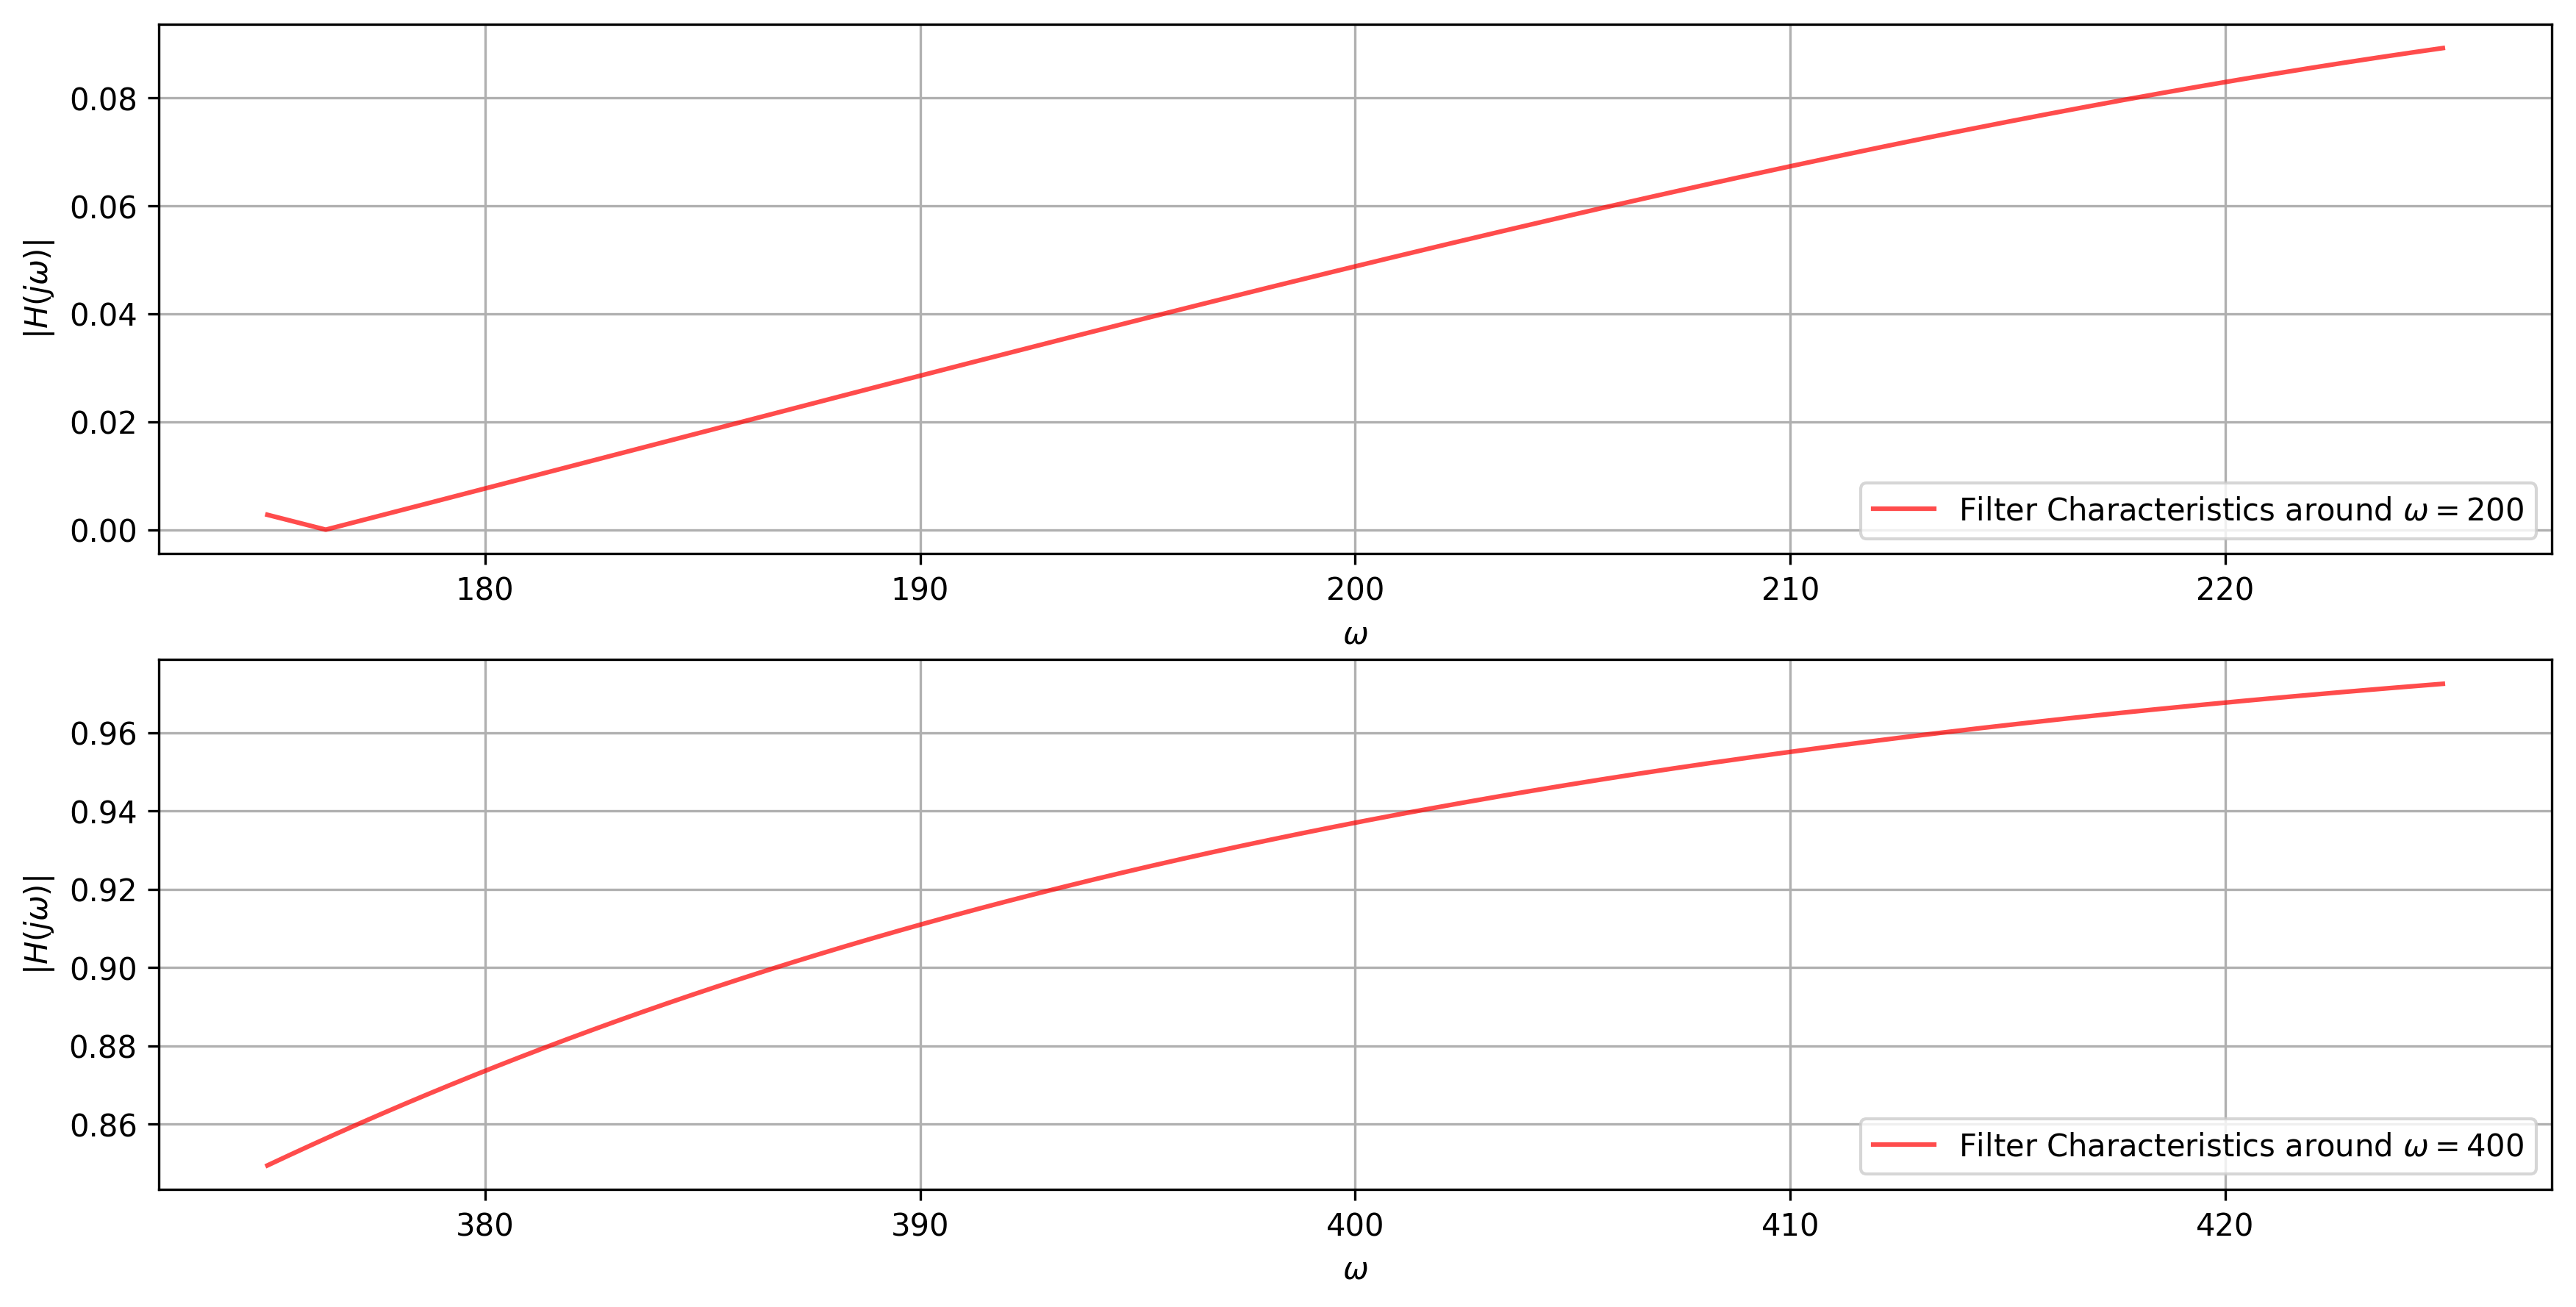

In [10]:
w1, h_mag1, _ = sig.bode(system, np.arange(175, 225, 0.001))
w2, h_mag2, _ = sig.bode(system, np.arange(375, 425, 0.001))
create_plot([w1, w2], [(10 ** (0.05 * h_mag1), ), (10 ** (0.05 * h_mag2), )],
            ["$\omega$", "$\omega$"], ["$|H(j\omega)|$", "$|H(j\omega)|$"],
            [("Filter Characteristics around $\omega=200$", ),
             ("Filter Characteristics around $\omega=400$", )], size=(14, 7), num_rows=2)

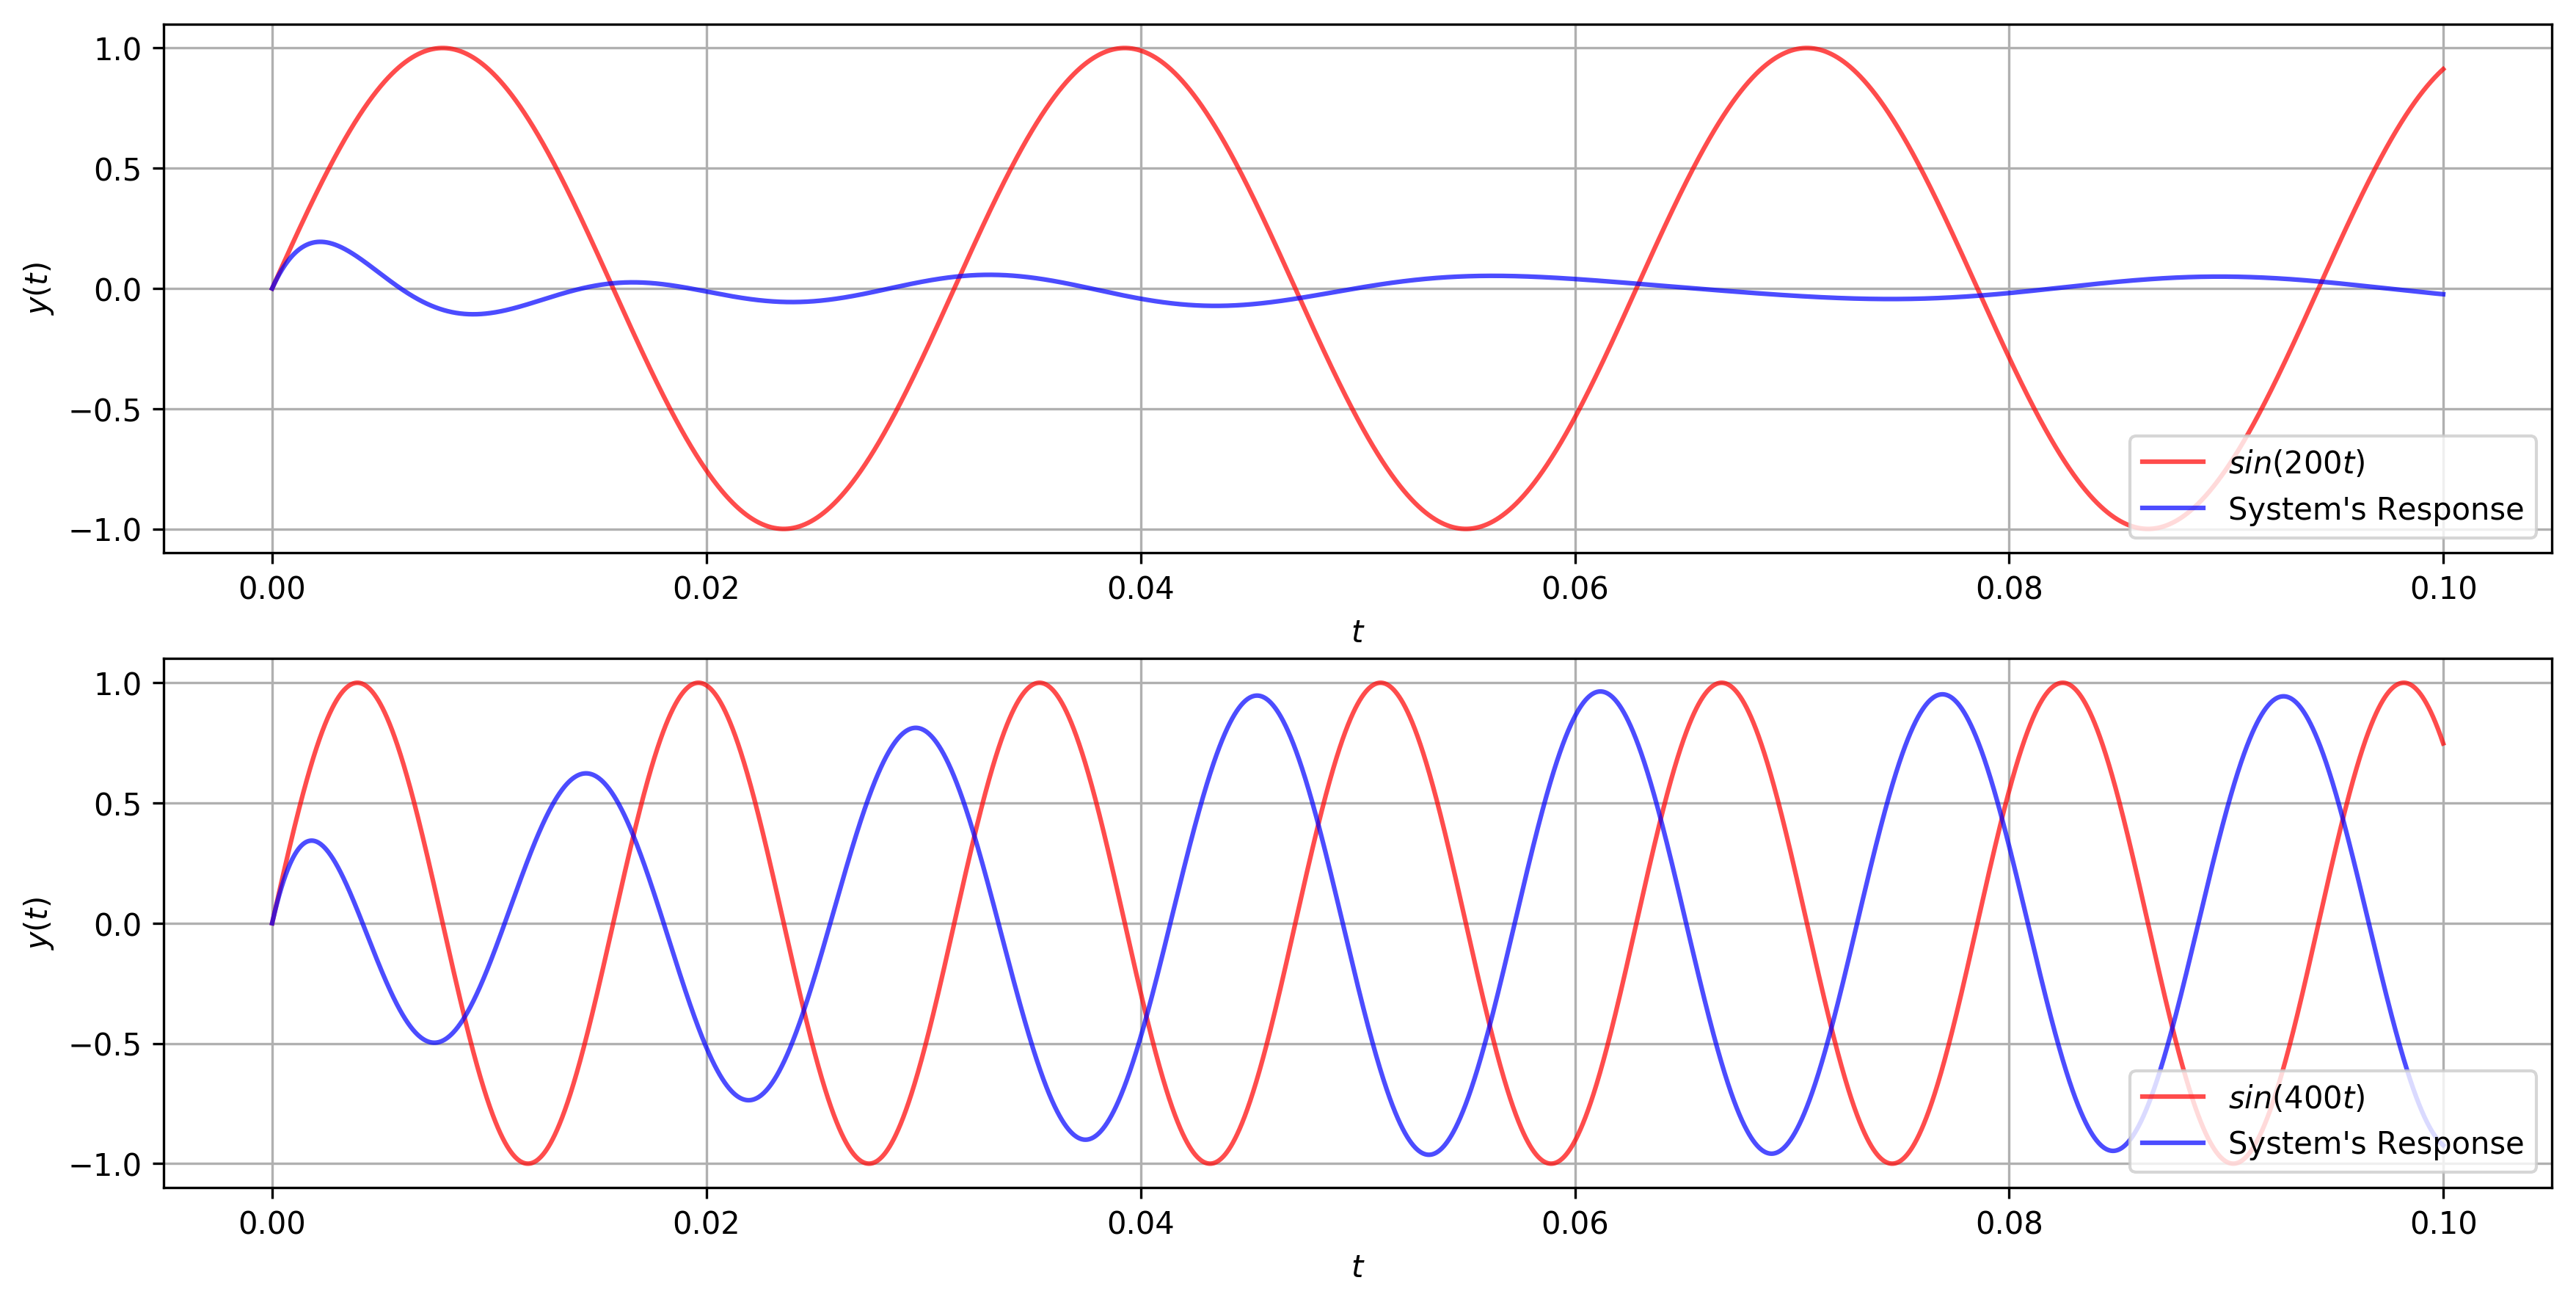

In [12]:
dt = 0.00001
NN = 10000
TT = np.arange(0, NN * dt, dt)
response_200 = np.zeros(NN)
response_400 = np.zeros(NN)
force_200 = np.zeros(NN)
force_400 = np.zeros(NN)

a, b, c, d = sig.tf2ss(final_num, final_den)
a, b, c, d = np.real(a), np.real(b), np.real(c), np.real(d)

for n in range(NN):
    force_200[n] = np.sin(200 * n * dt)
    force_400[n] = np.sin(400 * n * dt)
    
x_200 = np.zeros(np.shape(b))
x_400 = np.zeros(np.shape(b))
for m in range(NN):
    x_200 += dt * a.dot(x_200) + dt * b * force_200[m]
    x_400 += dt * a.dot(x_400) + dt * b * force_400[m]
    
    response_200[m] = c.dot(x_200) + d * force_200[m]
    response_400[m] = c.dot(x_400) + d * force_400[m]
    
create_plot([TT, TT],
            [(force_200, response_200), (force_400, response_400)],
            ["$t$", "$t$"], ["$y(t)$", "$y(t)$"],
            [("$sin(200t)$", "System's Response"),
             ("$sin(400t)$", "System's Response")], 2, size=(14, 7))